This notebook implements the idea provided as an answer to a [question](https://quantumcomputing.stackexchange.com/q/34432/9474) in quantum computing StackExchange about getting the relative phase of a certain basis state $|k\rangle$ in a given quantum state
$$|\psi\rangle = r_0|0\rangle + r_1e^{i\theta_1}|1\rangle + r_2e^{i\theta_2}|2\rangle + \ldots + r_k e^{i\theta_k}|k\rangle + \ldots + r_{t-1}e^{i\theta_{t - 1}}|t-1\rangle $$

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np

In [2]:
def construct_hadamard_test_circuit(init_circ, operator, imaginary=False):
    num_qubits = init_circ.num_qubits
    op_circ = QuantumCircuit(num_qubits)
    op_circ.unitary(operator, range(num_qubits))

    h_test = QuantumCircuit(num_qubits + 1)
    h_test.append(init.to_gate(label='    $\psi$    '), range(1, num_qubits + 1))
    h_test.barrier()
    h_test.h(0)
    if imaginary:
        h_test.sdg(0)
    h_test.append(op_circ.to_gate(label='$U(u_{00}, u_{0k}, u_{k0}, u_{kk})$').control(1), range(num_qubits + 1))
    h_test.h(0)
    return h_test

In [3]:
from qiskit import ClassicalRegister, transpile
from qiskit_aer import AerSimulator

SHOTS = 1000000

def get_prop(circ, sample=False):
    if sample:
        simulator = AerSimulator()
        if circ.num_clbits == 0:
            cr_aux = ClassicalRegister(1, "aux")
            circ.add_bits(cr_aux)
            circ.measure(0, 0)
        circ = transpile(circ, backend=simulator)
        job = simulator.run(circ, shots=SHOTS)
        return job.result().get_counts()['0'] / SHOTS
    else:
        return Statevector.from_label('0' * (circ.num_qubits)).evolve(circ).probabilities([0])[0]

In [4]:
def get_operator(n, k, a, b, c, d):
    op = np.eye(2 ** n)
    op[0][0] = a
    op[0][k] = b
    op[k][0] = c
    op[k][k] = d
    return op

In [6]:
n = 4 # number of qubits
k = 5 # |k⟩ is the basis state that we will try to get its phase
theta = np.pi / 3 # phase angle

k_bitstring = format(k, "#0" + str(n + 2) + "b").replace("0b", "")

init = QuantumCircuit(n)
init.h(range(n))
for idx, bit in enumerate(k_bitstring):
    if bit == "0":
        init.x(n - idx - 1, bit)
init.mcp(theta, list(range(n - 1)), n - 1)
for idx, bit in enumerate(k_bitstring):
    if bit == "0":
        init.x(n - idx - 1, bit)

psi = Statevector.from_instruction(init)
psi.draw('latex')

<IPython.core.display.Latex object>

In [7]:
alpha = 0.6
beta = 0.8

In [8]:
U_1 = get_operator(n, k, alpha, beta, -beta, alpha)
circ = construct_hadamard_test_circuit(init, U_1)
x1 = 2 * get_prop(circ) - 1
print('x1 =', x1)

x1 = 0.9500000000000028


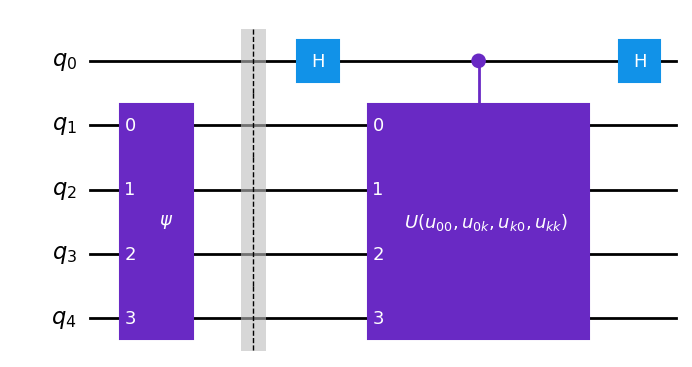

In [9]:
circ.draw('mpl', style='textbook')

In [10]:
from qiskit.visualization import array_to_latex

array_to_latex(U_1, max_size=2 ** n)

<IPython.core.display.Latex object>

In [11]:
circ = construct_hadamard_test_circuit(init, U_1, True)
y1 = 2 * get_prop(circ) - 1
print('y1 =', y1)

y1 = 0.08660254037844117


In [12]:
U_2 = get_operator(n, k, alpha, beta, beta, -alpha)
circ = construct_hadamard_test_circuit(init, U_2)
x2 = 2 * get_prop(circ) - 1
print('x2 =', x2)

x2 = 0.9250000000000003


In [13]:
U_3 = get_operator(n, k, beta, alpha, -alpha, beta)
circ = construct_hadamard_test_circuit(init, U_3)
x3 = 2 * get_prop(circ) - 1
print('x3 =', x3)

U_4 = get_operator(n, k, beta, alpha, alpha, -beta)
circ = construct_hadamard_test_circuit(init, U_4)
x4 = 2 * get_prop(circ) - 1
print('x4 =', x4)

x3 = 0.9750000000000028
x4 = 0.9125000000000014


In [14]:
r_squared = (beta * (x3 - x4) - alpha * (x1 - x2)) / (beta * beta - alpha * alpha) / 2
print('r =', np.sqrt(r_squared))

tan_theta = y1 / (2 * alpha * r_squared - (x1- x2))
print('theta =', np.arctan(tan_theta))

r = 0.24999999999999822
theta = 1.0471975511966158
